In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import explained_variance_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

file_house = "/home/malick/Bureau/Stage_Projet_RTS/usecase/x(g)boost/house_data.csv"

df = pd.read_csv(file_house)
#Col_obj = list(df.select_dtypes(include='object').columns)
#df[Col_obj] =df[Col_obj].astype(str) 

In [112]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [43]:
print(df.values.shape)
print(df.dtypes.unique())

(21613, 21)
[dtype('int64') dtype('O') dtype('float64')]


In [46]:
df.select_dtypes(include=['O']).columns.tolist()

['date']

In [49]:
# Check any number of columns with NaN
print(df.isnull().any(axis=0).sum(), ' / ', len(df.columns))

# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  21
0  /  21613


In [50]:
# Correlations between features and target
features = df.iloc[:,3:].columns.tolist()
target = df.iloc[:,2].name

data = df

correlations = {}

for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


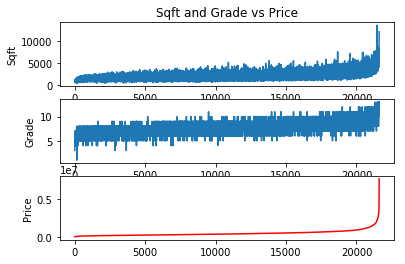

In [51]:
y = data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show()

In [32]:
########Predicting House Sales Prices########

In [58]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data.copy()
new_data.drop(["id","date","price"], axis='columns', inplace=True)

In [59]:
new_data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [101]:
X = new_data
y = data.price
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25)

In [102]:
regr.fit(X_train, y_train)
regr.score(X_test,y_test)

0.705317599619114

In [103]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 213190.31


In [108]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

traindf, testdf = train_test_split(X_train, test_size = 0.3)
eval_set = [(X_test, y_test)]
xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[10:52:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:623396
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:578888
[2]	validation_0-rmse:539526
[3]	validation_0-rmse:502537
[4]	validation_0-rmse:468567
[5]	validation_0-rmse:437434
[6]	validation_0-rmse:408400
[7]	validation_0-rmse:382406
[8]	validation_0-rmse:358693
[9]	validation_0-rmse:336818
[10]	validation_0-rmse:316510
[11]	validation_0-rmse:298267
[12]	validation_0-rmse:281656
[13]	validation_0-rmse:266222
[14]	validation_0-rmse:253133
[15]	validation_0-rmse:240612
[16]	validation_0-rmse:228791
[17]	validation_0-rmse:218116
[18]	validation_0-rmse:208950
[19]	validation_0-rmse:200197
[20]	validation_0-rmse:191908
[21]	validation_0-rmse:185095
[22]	validation_0-rmse:178679
[23]	validation_0-rmse:172750
[24]	validation_0-rmse:167438
[25]	validation_0-rmse:162382
[26]	validation_0-rmse:158465
[27]	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [109]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8927022593285902


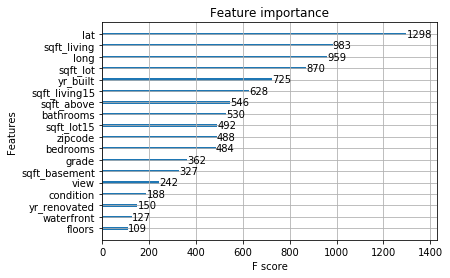

In [110]:
xgboost.plot_importance(xgb)
plt.show()